# Old notebook. Do not follow

# Import packages

In [1]:
# Import packages
from transformers import AutoModel, AutoTokenizer, AutoModelForCausalLM, AutoModelForMaskedLM
from peft import PeftModel, PeftConfig
from autoamp.evolveFinetune import *
import torch
from tqdm import tqdm
import math
from Bio import SeqIO 
import json
import warnings
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from transformers import PreTrainedTokenizer

warnings.filterwarnings("ignore")

2025-04-12 23:45:42.264985: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-12 23:45:42.284131: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-04-12 23:45:42.284162: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-12 23:45:42.297368: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-04-12 23:45:43.371378: W tensorflow/compiler/tf

# Functions

In [2]:
class HeatmapGenerator:
    def __init__(self, model=None, tokenizer=None, model_name=None, is_progen=False):
        """
        Initialize the HeatmapGenerator with either:
        1. A pre-loaded model and tokenizer
        2. A model_name to load from HuggingFace
        
        Args:
            model: A pre-loaded model instance
            tokenizer: A pre-loaded tokenizer
            model_name: HuggingFace model name (used only if model and tokenizer are None)
            is_progen: Set to True when using ProGen models that don't support MLM
        """
        self.is_progen = is_progen
        
        if model is not None and tokenizer is not None:
            # Use provided model and tokenizer
            self.model = model
            self.tokenizer = tokenizer
        elif model_name is not None:
            # Load model and tokenizer from HuggingFace
            if "progen" in model_name.lower():
                self.is_progen = True
                from transformers import AutoModelForCausalLM, AutoTokenizer
                self.tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
                self.model = AutoModelForCausalLM.from_pretrained(model_name, trust_remote_code=True)
            else:
                from transformers import EsmForMaskedLM, EsmTokenizer
                self.tokenizer = EsmTokenizer.from_pretrained(model_name)
                self.model = EsmForMaskedLM.from_pretrained(model_name)
            
            # Put model in evaluation mode if it has the method
            if hasattr(self.model, 'eval') and callable(self.model.eval):
                self.model.eval()
        else:
            raise ValueError("Either provide a model and tokenizer, or a model_name")

        # Print model type for debugging
        print(f"Using model type: {'ProGen' if self.is_progen else 'ESM'}")

    def _get_logits(self, input_ids, position=None):
        """
        Runs the model and extracts logits, handling different model interfaces.
        
        Args:
            input_ids: Tensor with input IDs or BatchEncoding
            position: Position in the original sequence (for error reporting)
            
        Returns:
            logits: Tensor of logits
        """
        with torch.no_grad():
            try:
                # Try different methods of running the model
                if hasattr(self.model, '__call__') and callable(self.model.__call__):
                    outputs = self.model(input_ids)
                elif hasattr(self.model, 'forward') and callable(self.model.forward):
                    outputs = self.model.forward(input_ids)
                elif hasattr(self.model, 'predict') and callable(self.model.predict):
                    outputs = self.model.predict(input_ids)
                elif hasattr(self.model, 'infer') and callable(self.model.infer):
                    outputs = self.model.infer(input_ids)
                else:
                    raise ValueError("Could not find a suitable method to run the model")
                
                # Extract logits from the model output
                if isinstance(outputs, torch.Tensor):
                    return outputs
                elif hasattr(outputs, 'logits'):
                    return outputs.logits
                elif isinstance(outputs, dict) and 'logits' in outputs:
                    return outputs['logits']
                elif isinstance(outputs, tuple) and len(outputs) > 0:
                    if isinstance(outputs[0], torch.Tensor):
                        return outputs[0]
                    elif hasattr(outputs[0], 'logits'):
                        return outputs[0].logits
                
                # If we get here, we couldn't identify the logits
                raise ValueError(f"Could not extract logits from model output: {type(outputs)}")
                
            except Exception as e:
                raise RuntimeError(f"Error running model at position {position}: {str(e)}")

    def llrData(self, protein_sequence, start_pos=1, end_pos=None):
        """
        Computes log likelihood ratio data for mutations at each position.
        Modified to work with both ESM (MLM) and ProGen (CLM) models.
        
        Args:
            protein_sequence: The protein sequence to analyze
            start_pos: The starting position (1-indexed) to analyze
            end_pos: The ending position (1-indexed) to analyze
            
        Returns:
            DataFrame with LLR values for each amino acid at each position
        """
        # Calculate sequence length
        sequence_length = len(protein_sequence)
    
        # Adjust end_pos if not specified or if it exceeds the actual sequence length
        if end_pos is None:
            end_pos = sequence_length
        end_pos = min(end_pos, sequence_length)
    
        # List of amino acids
        amino_acids = list("ACDEFGHIKLMNPQRSTVWY")
    
        # Initialize heatmap array: 20 rows (AAs) x (end_pos - start_pos + 1) columns
        heatmap = np.zeros((20, end_pos - start_pos + 1))

        # Process each position
        for position in range(start_pos, end_pos + 1):
            try:
                if not self.is_progen:
                    # ESM uses masked language modeling
                    # Tokenize the sequence
                    tokens = self.tokenizer(protein_sequence, return_tensors="pt")
                    input_ids = tokens["input_ids"]
                    
                    # Clone the input_ids to mask one position
                    masked_input_ids = input_ids.clone()
                    
                    # ESM position offset: Adjust if needed
                    token_position = position
                    
                    # Get the token ID for the mask token
                    mask_token_id = self.tokenizer.mask_token_id
                    if mask_token_id is None:
                        raise ValueError("Tokenizer doesn't have a mask token")
                    
                    # Mask the target position
                    masked_input_ids[0, token_position] = mask_token_id
                    
                    # Get logits from the model for masked position
                    logits = self._get_logits(masked_input_ids, position=position)
                    
                    # Get logits for the masked position
                    masked_position_logits = logits[0, token_position]
                    
                    # Get the wildtype residue ID from input_ids
                    wt_residue_id = input_ids[0, token_position].item()
                    
                else:  # ProGen or other causal models
                    # Use causal language modeling (predict next token)
                    
                    # For ProGen, we need special handling for the first position
                    if position <= 1:
                        # For the first position, use a single letter to avoid empty tensor
                        # This is just to get the vocabulary distribution
                        prefix = "A"  # Use any amino acid here
                    else:
                        # Extract the sequence up to the position we want to predict
                        prefix = protein_sequence[:position-1]  # -1 for 0-indexing
                    
                    # Tokenize just the prefix
                    prefix_tokens = self.tokenizer(prefix, return_tensors="pt")
                    
                    # Debug output to see what's happening
                    #print(f"Position {position}: Prefix '{prefix}', Prefix shape after tokenization: {prefix_tokens['input_ids'].shape}")
                    
                    # Run the model to get the next token prediction
                    logits = self._get_logits(prefix_tokens, position=position)
                    
                    # Get the last position logits (predicting the next token)
                    if logits.size(1) > 0:
                        masked_position_logits = logits[0, -1]
                    else:
                        # If we still get an empty tensor, use a default distribution
                        # For safety, create an array of zeros with the correct vocab size
                        vocab_size = len(self.tokenizer.get_vocab())
                        masked_position_logits = torch.zeros(vocab_size, device=logits.device)
                        print(f"Warning: Empty logits at position {position}, using zeros with shape {masked_position_logits.shape}")
                    
                    # For ProGen, get the wildtype residue directly from the sequence
                    wt_residue = protein_sequence[position-1]  # 0-indexed
                    # Map the character to a token ID
                    wt_residue_id = None
                    
                    # Try different ways to get the token ID
                    try:
                        # Method 1: Direct conversion
                        wt_residue_id = self.tokenizer.convert_tokens_to_ids(wt_residue)
                        
                        # Method 2: Try as a list
                        if wt_residue_id is None or wt_residue_id == 0:
                            wt_residue_id = self.tokenizer.convert_tokens_to_ids([wt_residue])[0]
                            
                        # Method 3: Use encode
                        if wt_residue_id is None or wt_residue_id == 0:
                            encoded = self.tokenizer.encode(wt_residue, add_special_tokens=False)
                            if len(encoded) > 0:
                                wt_residue_id = encoded[0]
                        
                        print(f"Wildtype residue '{wt_residue}' at position {position} mapped to token ID {wt_residue_id}")
                    except Exception as e:
                        # If all methods fail, print a warning
                        print(f"Warning: Could not convert '{wt_residue}' to a token ID: {str(e)}")
                
                # Convert to probabilities and log probabilities
                probs = torch.nn.functional.softmax(masked_position_logits, dim=0)
                log_probs = torch.log(probs)
    
                # Set up wildtype log probability
                log_prob_wt = 0.0
                if wt_residue_id is not None:
                    try:
                        log_prob_wt = log_probs[wt_residue_id].item()
                    except (IndexError, TypeError) as e:
                        # If the ID is out of range, use 0.0
                        print(f"Warning: Token ID {wt_residue_id} for wildtype at position {position} is out of range: {str(e)}")
                        log_prob_wt = 0.0
    
                # Compute LLRs for all 20 amino acids
                for i, aa in enumerate(amino_acids):
                    try:
                        # Get token ID for the amino acid - try multiple methods
                        aa_id = None
                        
                        # Method 1: Direct conversion
                        aa_id = self.tokenizer.convert_tokens_to_ids(aa)
                        
                        # Method 2: Try as a list
                        if aa_id is None or aa_id == 0:
                            aa_id = self.tokenizer.convert_tokens_to_ids([aa])[0]
                            
                        # Method 3: Use encode
                        if aa_id is None or aa_id == 0:
                            # Skip special tokens when encoding
                            encoded = self.tokenizer.encode(aa, add_special_tokens=False)
                            if len(encoded) > 0:
                                aa_id = encoded[0]
                        
                        # If token ID exists, compute log likelihood ratio
                        if aa_id is not None and aa_id > 0:
                            try:
                                log_prob_mut = log_probs[aa_id].item()
                                heatmap[i, position - start_pos] = log_prob_mut - log_prob_wt
                            except IndexError as e:
                                # If the ID is out of range, use 0.0
                                print(f"Warning: Token ID {aa_id} for '{aa}' is out of range: {str(e)}")
                                heatmap[i, position - start_pos] = 0.0
                        else:
                            # Skip tokens not in the vocabulary
                            heatmap[i, position - start_pos] = 0.0
                    except Exception as e:
                        print(f"Error processing amino acid '{aa}' at position {position}: {str(e)}")
                        heatmap[i, position - start_pos] = 0.0
                    
            except Exception as e:
                print(f"Error processing position {position}: {str(e)}")
                # Fill with zeros for this position
                heatmap[:, position - start_pos] = 0
    
        # Create a DataFrame for readability
        columns = [f"{pos}" for pos in range(start_pos, end_pos + 1)]
        df = pd.DataFrame(heatmap, index=amino_acids, columns=columns)
        return df

        

    def generate_heatmap(self, protein_sequence, start_pos=1, end_pos=None, figsize=(10, 5), 
                        cmap="viridis", tick_interval=5, title=None):
        """
        Plots the heatmap of log_prob_mutant - log_prob_wildtype.
        
        Args:
            protein_sequence: The protein sequence to analyze
            start_pos: The starting position (1-indexed) to analyze
            end_pos: The ending position (1-indexed) to analyze
            figsize: Figure size (width, height) in inches
            cmap: Colormap to use for the heatmap
            tick_interval: Label x-axis ticks at this interval
            title: Custom title for the plot (if None, uses default)
            
        Returns:
            matplotlib figure object
        """
        df = self.llrData(protein_sequence, start_pos, end_pos)
        heatmap = df.values  # shape [20, num_positions]

        fig, ax = plt.subplots(figsize=figsize)
        cax = ax.imshow(heatmap, cmap=cmap, aspect="auto")

        ax.set_xticks(range(heatmap.shape[1]))  # Set ticks for every position
        ax.set_xticklabels(
            [df.columns[i] if i % tick_interval == 0 else "" for i in range(len(df.columns))],
            rotation=90,
            fontsize=8
        )

        ax.set_yticks(range(20))
        ax.set_yticklabels(df.index)

        ax.set_xlabel("Position in Protein Sequence")
        ax.set_ylabel("Amino Acid Mutations")
        
        model_type = "ProGen2" if self.is_progen else "ESM"
        if title is None:
            title = f"Predicted Effects of Mutations ({model_type} Model)"
        ax.set_title(title)

        cbar = fig.colorbar(cax, ax=ax)
        cbar.set_label("Log Likelihood Ratio (mutant vs. wild-type)")
        
        plt.tight_layout()
        return fig

    def save_heatmap_data(self, protein_sequence, filename, start_pos=1, end_pos=None):
        """
        Compute the LLR data and save it to a CSV file
        
        Args:
            protein_sequence: The protein sequence to analyze
            filename: Path to save the CSV file
            start_pos: The starting position (1-indexed) to analyze
            end_pos: The ending position (1-indexed) to analyze
            
        Returns:
            DataFrame containing the LLR data
        """
        df = self.llrData(protein_sequence, start_pos, end_pos)
        df.to_csv(filename)
        return df
        
def parse_mutation(mutation_str):
    # Find the position (number) in the mutation string
    i = 0
    while i < len(mutation_str) and not mutation_str[i].isdigit():
        i += 1
    j = i
    while j < len(mutation_str) and mutation_str[j].isdigit():
        j += 1
    
    original = mutation_str[:i]
    position = int(mutation_str[i:j])
    new = mutation_str[j:]
    
    return (original, position, new)


# Load models

In [3]:
base_model_name = "facebook/esm2_t30_150M_UR50D" 
tokenizer = AutoTokenizer.from_pretrained(base_model_name)
adapter_checkpoint = "/home/sdowell/scratch/Thesis/ADP1/runs/esm2_dgoa_finetune_1/checkpoint-3000"

# Pretrained model
model_pretrained = AutoModelForMaskedLM.from_pretrained(base_model_name)

# Finetuned model
model_with_adapter = AutoModelForMaskedLM.from_pretrained(base_model_name)
#model_finetuned = PeftModel.from_pretrained(model_with_adapter, adapter_checkpoint)
model_finetuned = LoRAEsm2ProteinLanguageModel(
    base_model_name=base_model_name,
    checkpoint_path=adapter_checkpoint
)


model_finetuned = PeftModel.from_pretrained(model_with_adapter, adapter_checkpoint)

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#model_pretrained.to(device).eval()
#model_finetuned.to(device).eval()

total_params = sum(p.numel() for p in model_finetuned.parameters())
trainable_params = sum(p.numel() for p in model_finetuned.parameters() if p.requires_grad)

print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")
print(f"Trainable ratio: {100 * trainable_params / total_params:.2f}%")


Total parameters: 149,843,867
Trainable parameters: 432,673
Trainable ratio: 0.29%


# Prepare DgoA mutations

In [4]:
DgoA_seq = ('MQWQTKLPLIAILRGITPDEALAHVGAVIDAGFDAVEIPLNSPQWEQSIPAIVDAYGDKA'
'LIGAGTVLKPEQVDALARMGCQLIVTPNIHSEVIRRAVGYGMTVCPGCATATEAFTALEA'
'GAQALKIFPSSAFGPQYIKALKAVLPSDIAVFAVGGVTPENLAQWIDAGCAGAGLGSDLY'
'RAGQSVERTAQQAAAFVKAYREAVQ')

mutations = ['F33I','D58N','A75V','Q72H','V85A','V154F','Y180F']

Dgoa_mut_seqs = []

# Convert all mutation strings into tuples
mutation_tuples = [parse_mutation(m) for m in mutations]
#print(mutation_tuples)

# Mutate DgoA sequence
for orig_aa, pos, new_aa in mutation_tuples:
    if DgoA_seq[pos - 1] != orig_aa:
        print(f"Warning: expected {orig_aa} at position {pos}, but found {DgoA_seq[pos - 1]}")
    # Apply mutation
    mutated_seq = DgoA_seq[:pos - 1] + new_aa + DgoA_seq[pos:]
    Dgoa_mut_seqs.append(mutated_seq)

In [5]:
'''
heatmap_generator = HeatmapGenerator(
    model_pretrained=model_pretrained,
    model_finetuned=model_finetuned,
    tokenizer=tokenizer
)


# Generate and plot
fig = heatmap_generator.generate_heatmap(
    protein_sequence=DgoA_seq,
    start_pos=1,
    end_pos=len(DgoA_seq),
    title="LLR Heatmap: Fine-tuned vs Pretrained ESM2",
    figsize=(15, 5),
    tick_interval=20
)

# Save LLR data
df = heatmap_generator.save_heatmap_data(
    protein_sequence=DgoA_seq,
    start_pos=1,
    end_pos=len(DgoA_seq),
    filename="DeltaLLR_esm2_dgoa.csv"
)
'''

'\nheatmap_generator = HeatmapGenerator(\n    model_pretrained=model_pretrained,\n    model_finetuned=model_finetuned,\n    tokenizer=tokenizer\n)\n\n\n# Generate and plot\nfig = heatmap_generator.generate_heatmap(\n    protein_sequence=DgoA_seq,\n    start_pos=1,\n    end_pos=len(DgoA_seq),\n    title="LLR Heatmap: Fine-tuned vs Pretrained ESM2",\n    figsize=(15, 5),\n    tick_interval=20\n)\n\n# Save LLR data\ndf = heatmap_generator.save_heatmap_data(\n    protein_sequence=DgoA_seq,\n    start_pos=1,\n    end_pos=len(DgoA_seq),\n    filename="DeltaLLR_esm2_dgoa.csv"\n)\n'

In [6]:
#LLR_scores = heatmap_generator.compute_llr(DgoA_seq, 0, len(DgoA_seq))

Using model type: ESM
Generating complete heatmap...
Analysis complete!


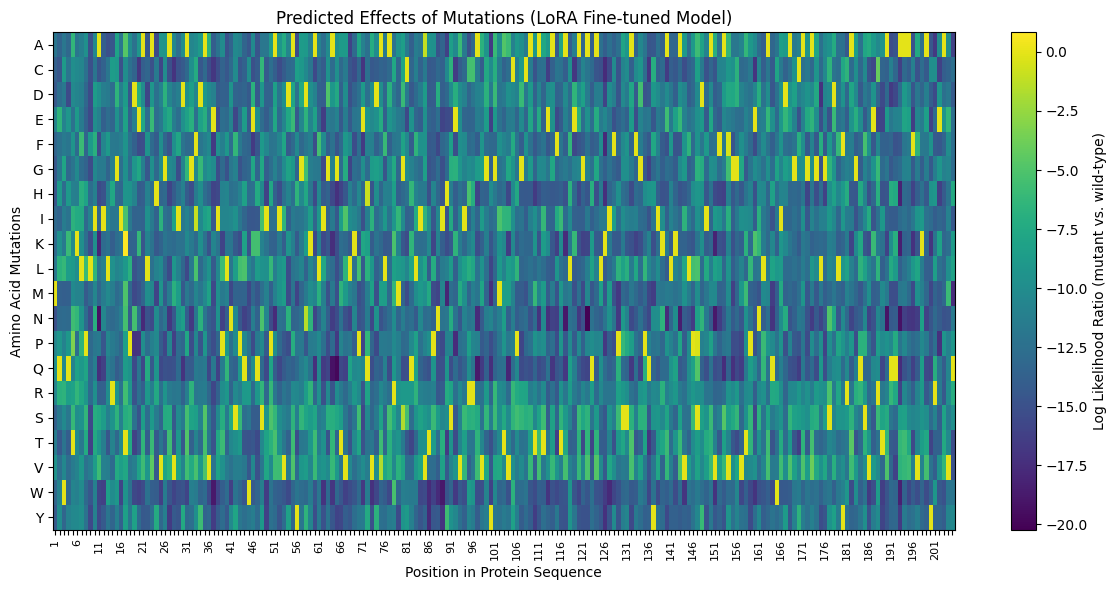

In [7]:
import traceback

# Initialize the heatmap generator
heatmap_generator = HeatmapGenerator(model=model_finetuned, tokenizer=tokenizer)

try:
    # Full analysis
    print("Generating complete heatmap...")
    full_fig = heatmap_generator.generate_heatmap(
        protein_sequence=DgoA_seq,
        start_pos=1,
        end_pos=len(DgoA_seq),  # First 50 positions to start
        title="Predicted Effects of Mutations (LoRA Fine-tuned Model)",
        figsize=(12, 6),
        tick_interval=5
    )
    full_fig.savefig("dgoa_esm_finetuned_llr_data.png", dpi=300)
    
    # Save data
    df = heatmap_generator.save_heatmap_data(
        protein_sequence=DgoA_seq,
        filename="dgoa_esm_finetuned_llr_data.csv",
        start_pos=1,
        end_pos=len(DgoA_seq)
    )
    print("Analysis complete!")
    
except Exception as e:
    print(f"Error during testing: {str(e)}")
    traceback.print_exc()

Using model type: ESM
Generating complete heatmap...
Analysis complete!


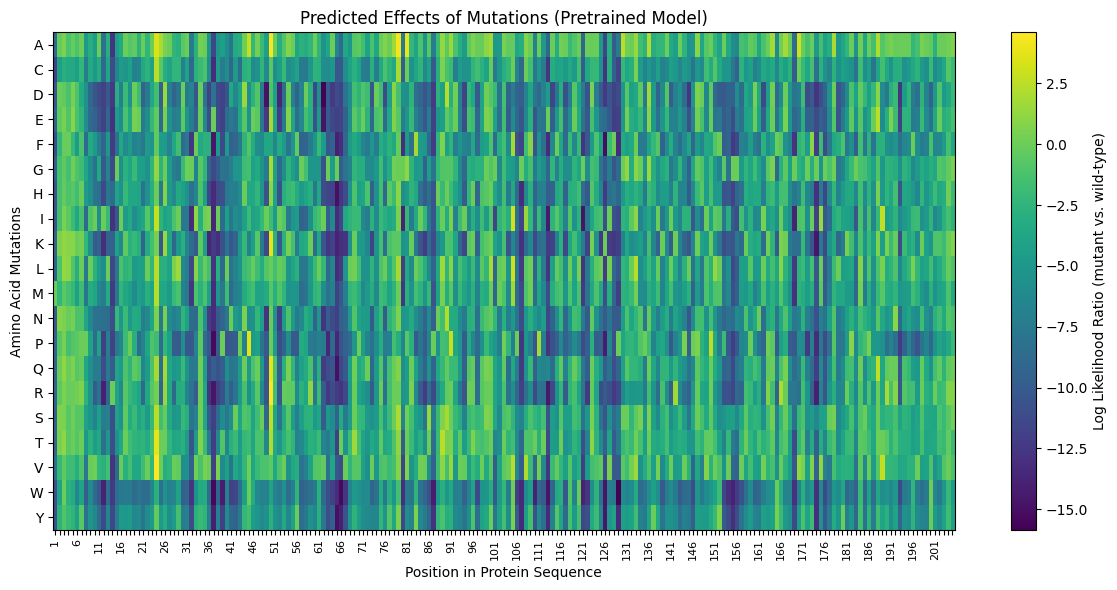

In [8]:
import traceback

# Initialize the heatmap generator
heatmap_generator = HeatmapGenerator(model=model_pretrained, tokenizer=tokenizer)

try:
    # Full analysis
    print("Generating complete heatmap...")
    full_fig = heatmap_generator.generate_heatmap(
        protein_sequence=DgoA_seq,
        start_pos=1,
        end_pos=len(DgoA_seq),  # First 50 positions to start
        title="Predicted Effects of Mutations (Pretrained Model)",
        figsize=(12, 6),
        tick_interval=5
    )
    full_fig.savefig("dgoa_esm_pretrained_llr_data.png", dpi=300)
    
    # Save data
    df = heatmap_generator.save_heatmap_data(
        protein_sequence=DgoA_seq,
        filename="dgoa_esm_pretrained_llr_data.csv",
        start_pos=1,
        end_pos=len(DgoA_seq)
    )
    print("Analysis complete!")
    
except Exception as e:
    print(f"Error during testing: {str(e)}")
    traceback.print_exc()

In [9]:
model_pretrained

EsmForMaskedLM(
  (esm): EsmModel(
    (embeddings): EsmEmbeddings(
      (word_embeddings): Embedding(33, 640, padding_idx=1)
      (dropout): Dropout(p=0.0, inplace=False)
      (position_embeddings): Embedding(1026, 640, padding_idx=1)
    )
    (encoder): EsmEncoder(
      (layer): ModuleList(
        (0-29): 30 x EsmLayer(
          (attention): EsmAttention(
            (self): EsmSelfAttention(
              (query): Linear(in_features=640, out_features=640, bias=True)
              (key): Linear(in_features=640, out_features=640, bias=True)
              (value): Linear(in_features=640, out_features=640, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
              (rotary_embeddings): RotaryEmbedding()
            )
            (output): EsmSelfOutput(
              (dense): Linear(in_features=640, out_features=640, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (LayerNorm): LayerNorm((640,), eps=1e-05, elementwise

In [10]:
model_finetuned

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): EsmForMaskedLM(
      (esm): EsmModel(
        (embeddings): EsmEmbeddings(
          (word_embeddings): Embedding(33, 640, padding_idx=1)
          (dropout): Dropout(p=0.0, inplace=False)
          (position_embeddings): Embedding(1026, 640, padding_idx=1)
        )
        (encoder): EsmEncoder(
          (layer): ModuleList(
            (0-29): 30 x EsmLayer(
              (attention): EsmAttention(
                (self): EsmSelfAttention(
                  (query): Linear(in_features=640, out_features=640, bias=True)
                  (key): lora.Linear(
                    (base_layer): Linear(in_features=640, out_features=640, bias=True)
                    (lora_dropout): ModuleDict(
                      (default): Dropout(p=0.1, inplace=False)
                    )
                    (lora_A): ModuleDict(
                      (default): Linear(in_features=640, out_features=8, bias=False)
                    )
  